In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

import warnings 
warnings.filterwarnings('ignore')

### Sequential Modelling using LSTM

We will build a sequential neural network to model the time series. The steps are as follows:
1. **Data Normalization:** Since the amount of data is less, normalization helps convergence faster.
2. **Feature Engineering:** For a timestep $t$, features can be trailing values $X_{t-i}$ while the target becomes the value at current timestamp $X_{t}$.
    1. Equal weighting for features
    2. Unequal weighting: For example - Exponential Moving Average 
3. **Train-Validation Split:** Since the examples are indexed in time, we cannot split the data in random fashion. 
    1. The validation data is last few examples. 
    2. At the same time, during training, the examples cannot be shuffled.
4. **Training:** Building the NN and training the network.
5. **Inference:** 
    1. Prediction for validation data
    2. Inverse Transform for Normalization
    3. Evaluation using Regression metrics

In [2]:
num_timesteps = 2
num_features = 1
val_pct = 0.1

batch_size = 1
learning_rate = 1E-4
n_epochs = 100

In [3]:
df = pd.read_csv('airline-passengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

scaler = StandardScaler()
df_orig = df.copy()
df['Passengers'] = scaler.fit_transform(df[['Passengers']])

### Important Points:

1. We will use past values as features for predicting value at current timestep. So, we are building a sequence with 1 value per timestamp.
2. Shape of data for the sequential network is [batch_size, num_timestamps, num_features].
3. Since the examples are related to each other, the LSTM layers are going to be **stateful**.
4. As we require the LSTM output for the final state only, we will have <code>return_sequences=False</code> for 2nd LSTM. 
5. However, for 1st LSTM, in order to keep three dimensions for input as required by 2nd LSTM, we will have <code>return_sequences=True</code>.

In [4]:
def make_data(df, num_timesteps):
    for idx in range(1, num_timesteps+1):
        iter_df = pd.DataFrame(df['Passengers'].shift(idx))
        iter_df.rename(columns={'Passengers':f'shift_{idx}'}, inplace=True)
        df = pd.concat([df, iter_df], axis=1)
    df.dropna(inplace=True)
    return df

df = make_data(df, num_timesteps)

In [5]:
val_size = int(len(df) * val_pct)

train_df = df[:-val_size]
val_df = df[-val_size:]

X_train = train_df.values[:, 1:].reshape(-1, num_timesteps, num_features)
y_train = train_df.values[:, 0]
X_val = val_df.values[:, 1:].reshape(-1, num_timesteps, num_features)
y_val = val_df.values[:, 0]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((128, 2, 1), (128,), (14, 2, 1), (14,))

In [6]:
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, stateful=True))
model.add(LSTM(50, activation='tanh', return_sequences=False, stateful=True))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.build(input_shape=(batch_size, num_timesteps, num_features))
model.summary()

2022-03-30 15:59:52.979233: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 2, 100)               40800     
                                                                 
 lstm_1 (LSTM)               (1, 50)                   30200     
                                                                 
 dropout (Dropout)           (1, 50)                   0         
                                                                 
 dense (Dense)               (1, 1)                    51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

estop = EarlyStopping(patience=5)
history = model.fit(X_train, y_train, epochs = n_epochs, shuffle = False, 
                    batch_size = batch_size, validation_split = 0.2, verbose=2, callbacks=[estop])

Epoch 1/100
102/102 - 3s - loss: 0.6741 - val_loss: 1.1512 - 3s/epoch - 31ms/step
Epoch 2/100
102/102 - 0s - loss: 0.6601 - val_loss: 1.0499 - 229ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.6553 - val_loss: 0.9036 - 214ms/epoch - 2ms/step
Epoch 4/100
102/102 - 0s - loss: 0.6532 - val_loss: 0.7998 - 213ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.6458 - val_loss: 0.7127 - 215ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 0.6377 - val_loss: 0.6410 - 213ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.6498 - val_loss: 0.6246 - 216ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.6318 - val_loss: 0.5582 - 214ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 0.6439 - val_loss: 0.5379 - 212ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.6266 - val_loss: 0.5179 - 211ms/epoch - 2ms/step
Epoch 11/100
102/102 - 0s - loss: 0.6277 - val_loss: 0.4910 - 210ms/epoch - 2ms/step
Epoch 12/100
102/102 - 0s - loss: 0.6297 - val_loss: 0.5005 - 209ms/epoch - 

In [8]:
def plotting(train_loss, val_loss):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(train_loss, label = 'Train Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend()
    plt.show()

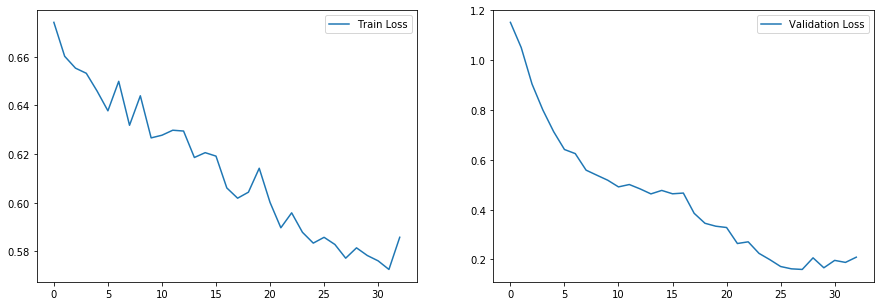

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)

In [10]:
def get_predictions(idx):
    return model.predict(np.expand_dims(X_val[idx], axis=0))[0]

y_pred = np.array(list(map(lambda idx: get_predictions(idx), range(len(X_val)))))
y_pred = scaler.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred)
mean_absolute_error(y_val, y_pred)

443.3941828703473

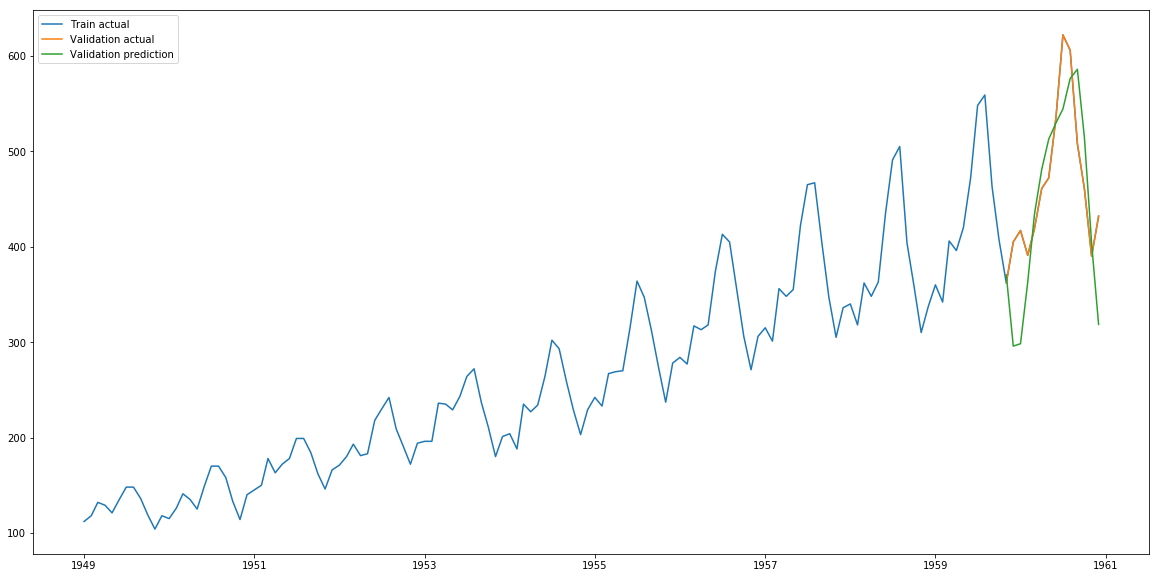

In [11]:
val_df_orig = df_orig[-val_size:]
val_df_orig['predictions'] = y_pred

plt.figure(figsize=(20,10))
plt.plot(df_orig['Passengers'], label = 'Train actual')
plt.plot(val_df_orig['Passengers'], label = 'Validation actual')
plt.plot(val_df_orig['predictions'], label = 'Validation prediction')
plt.legend()
plt.show()